# Baseline - ResNet50

In [5]:
import sys
sys.path.append('/Users/jinjishen/Desktop/fashion-dataset')
from imports import *

In [6]:
# Step 1: Feature Extraction Model Definition
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        # Load pre-trained ResNet50 model
        self.resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        # Remove the fully connected layer
        self.resnet50 = nn.Sequential(*list(self.resnet50.children())[:-2])
        # Add AdaptiveMaxPool2d to replace the average pool
        self.global_max_pool = nn.AdaptiveMaxPool2d((1, 1))

    def forward(self, x):
        x = self.resnet50(x)
        x = self.global_max_pool(x)
        return x

# Initialize the model
def initialize_model():
    model = FeatureExtractor()
    model.eval()
    return model

# Step 2: Feature Extraction Function
def extract_features(image_path, model):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    try:
        img = Image.open(image_path).convert('RGB')
        img_tensor = preprocess(img).unsqueeze(0)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        img_tensor = img_tensor.to(device)
        model = model.to(device)
        with torch.no_grad():
            features = model(img_tensor).flatten().cpu().numpy()
        return features / np.linalg.norm(features)
    except FileNotFoundError:
        print(f"File not found: {image_path}")
        return None

# Step 3: Building the Image Embeddings
def build_image_embeddings(df, model):
    embeddings = []
    for image_path in tqdm(df['path']):
        embedding = extract_features(image_path, model)
        if embedding is not None:
            embeddings.append(embedding)
    return np.array(embeddings)

# Step 4: Save Embeddings as CSV
def save_embeddings_to_csv(embeddings, df, filename='image_embeddings.csv'):
    embeddings_df = pd.DataFrame(embeddings)
    embeddings_df['id'] = df['id']
    embeddings_df['path'] = df['path']
    embeddings_df.to_csv(filename, index=False)
    print(f"Embeddings saved to {filename}")

# Step 5: TSNE Visualization
def visualize_tsne(embeddings, df, labels_columns=['masterCategory', 'subCategory']):
    """
    Visualize t-SNE embeddings with multiple label columns.

    Parameters:
    - embeddings (numpy array): Embeddings to be visualized with t-SNE.
    - df (pd.DataFrame): DataFrame containing the labels and metadata.
    - labels_columns (list): List of columns in df to use as labels for t-SNE visualization.
    """
    # Perform t-SNE
    tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300, random_state=42)
    tsne_results = tsne.fit_transform(embeddings)
    df['tsne-2d-one'] = tsne_results[:, 0]
    df['tsne-2d-two'] = tsne_results[:, 1]
    
    # Create subplots based on the number of label columns
    num_plots = len(labels_columns)
    plt.figure(figsize=(8 * num_plots, 10))
    
    for i, label_col in enumerate(labels_columns, start=1):
        plt.subplot(1, num_plots, i)
        sns.scatterplot(
            x="tsne-2d-one", y="tsne-2d-two",
            hue=label_col,
            palette=sns.color_palette("hsv", len(df[label_col].unique())),
            data=df,
            legend="full",
            alpha=0.8
        )
        plt.title(f't-SNE Visualization by {label_col}')
        plt.legend(loc='best', bbox_to_anchor=(1, 1))  # Move legend outside the plot
    
    plt.tight_layout()
    plt.show()

# Step 6: Similarity Search
def find_similar_images(input_embedding, embeddings, k=10, input_index=None):
    """
    Finds the top K similar images based on cosine similarity, excluding the input image itself.
    
    Parameters:
    - input_embedding (numpy array): The embedding of the input image.
    - embeddings (numpy array): Array of all precomputed image embeddings.
    - k (int): Number of similar images to return (default is 10).
    - input_index (int): The index of the input image in the embeddings array (if known).

    Returns:
    - top_k_indices (list): List of indices for the top K similar images, excluding the input image itself.
    """
    similarities = cosine_similarity([input_embedding], embeddings)[0]
    
    # If input_index is provided, exclude it from the list of similarities
    if input_index is not None:
        similarities[input_index] = -np.inf  # Set the similarity of the input image to itself as negative infinity
    
    # Get the top K similar indices
    top_k_indices = similarities.argsort()[-k:][::-1]
    return top_k_indices

# Step 7: Visualization of Similar Images
def plot_similar_images(input_image_path, top_k_indices, df, input_image_id=None):
    """
    Plot the input image along with the top K similar product images and their product IDs.

    Parameters:
    - input_image_path (str): Path to the input image to be displayed.
    - top_k_indices (list): List of indices of the top K similar products.
    - df (pd.DataFrame): DataFrame containing product IDs and image paths.
    - input_image_id (str or int): ID of the input image to be displayed with the input image (optional).
    """
    num_images = len(top_k_indices)
    plt.figure(figsize=(15, 5))

    # Plot input image with ID if provided
    img = Image.open(input_image_path)
    plt.subplot(1, num_images + 1, 1)
    plt.imshow(img)
    title = "Input Image"
    if input_image_id is not None:
        title += f"\nID: {input_image_id}"
    plt.title(title)
    plt.axis('off')

    # Plot similar images
    for i, idx in enumerate(top_k_indices, start=2):
        img_path = df.iloc[idx]['path']
        product_id = df.iloc[idx]['id']
        img = Image.open(img_path)
        plt.subplot(1, num_images + 1, i)
        plt.imshow(img)
        plt.title(f"ID: {product_id}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    
# Step 8: Pipeline for Image-Based Recommendation
def image_recommendation_pipeline(df, model, k=10, n_samples=3, save_embeddings=True, visualize_tsne_labels='masterCategory'):
    # Step 8.1: Build image embeddings
    print("Building image embeddings...")
    image_embeddings = build_image_embeddings(df, model)
    
    # Step 8.2: Save embeddings to CSV if required
    if save_embeddings:
        save_embeddings_to_csv(image_embeddings, df, '/Users/jinjishen/Desktop/fashion-dataset/image_embeddings.csv')
    
    # Step 8.3: Visualize with t-SNE
    visualize_tsne(embeddings=image_embeddings, df=sampled_df, labels_columns=['masterCategory', 'subCategory'])
    
    # Step 8.4: Randomly select images for recommendation
    random_images = df['path'].sample(n_samples).values
    for img_path in random_images:
        input_embedding = extract_features(img_path, model)
        
        # Find the index of the input image in the embeddings array
        input_index = df[df['path'] == img_path].index[0]  # Assuming 'path' is unique in the dataframe
        input_image_id = df.iloc[input_index]['id']  # Get the input image ID
        
        # Get the top K similar products excluding the input image itself
        top_k_indices = find_similar_images(input_embedding, image_embeddings, k, input_index=input_index)
        
        # Plot the input image and its top K recommendations
        plot_similar_images(img_path, top_k_indices, df, input_image_id=input_image_id)

Building image embeddings...


100%|██████████| 4440/4440 [08:36<00:00,  8.60it/s]


Embeddings saved to /Users/jinjishen/Desktop/fashion-dataset/image_embeddings.csv


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


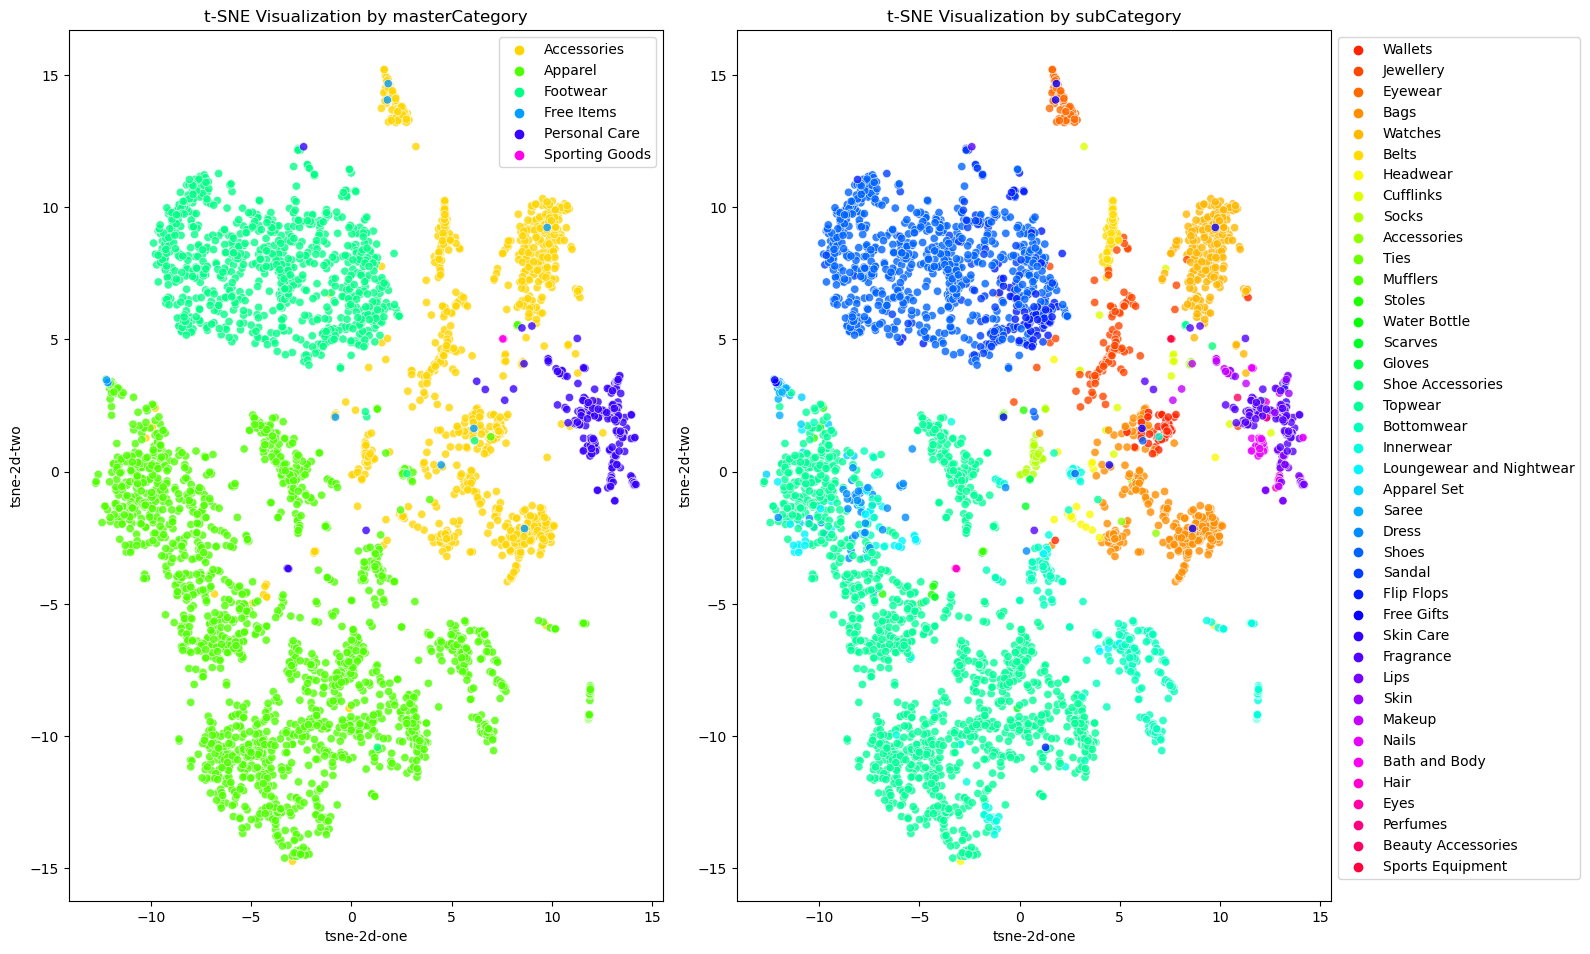

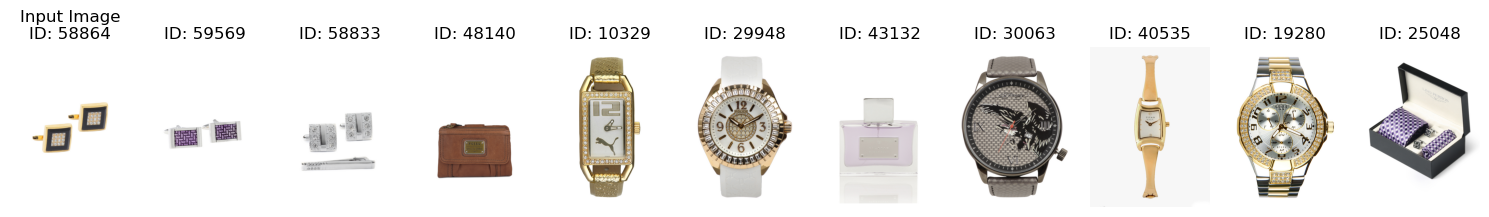

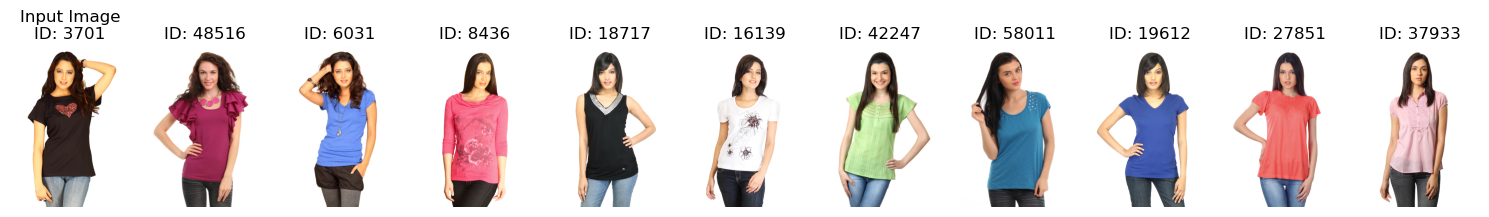

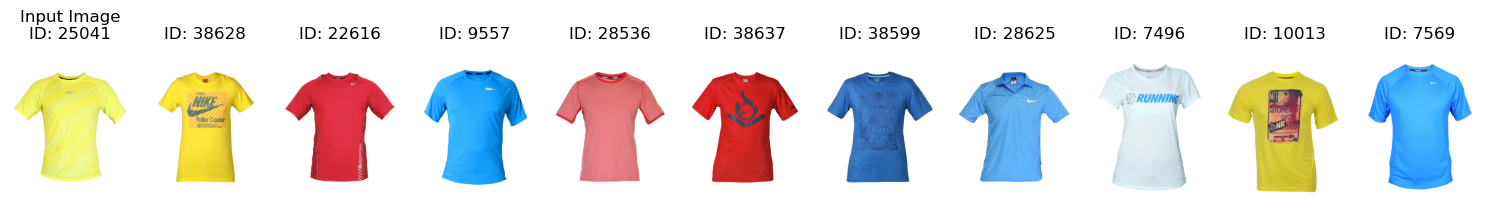

In [7]:
# Example usage
if __name__ == "__main__":
    sampled_df = pd.read_csv('/Users/jinjishen/Desktop/fashion-dataset/sampled_df.csv')
    sampled_df = sampled_df[sampled_df['id'] != 39410].reset_index(drop=True)  # Remove missing image
    model = initialize_model()
    image_recommendation_pipeline(sampled_df, model, k=10, n_samples=3)

# Combined with Metadata

In [ ]:
# Encode categorical variables
sampled_df = pd.read_csv('/Users/jinjishen/Desktop/fashion-dataset/sampled_df.csv')
sampled_df = sampled_df[sampled_df['id'] != 39410].reset_index(drop=True)
cat = ['gender','masterCategory','subCategory','baseColour','season','usage']
encoder = OneHotEncoder()
encoded_metadata = encoder.fit_transform(sampled_df[cat])

In [69]:
img_emb = pd.read_csv('/Users/jinjishen/Desktop/fashion-dataset/image_embeddings.csv')
combined_features = np.concatenate([img_emb, encoded_metadata.toarray()], axis=1)

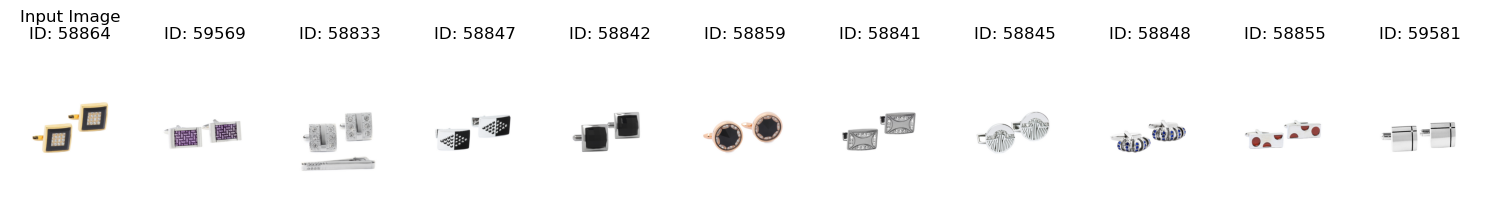

In [74]:
def test_similarity_for_sample_id(sample_id, sampled_df, img_emb, encoded_metadata, model, encoder, categorical_columns, k=10):
    """
    Test the similarity search for a given sample ID and visualize the results.

    Parameters:
    - sample_id (int): ID of the sample to test.
    - sampled_df (pd.DataFrame): DataFrame containing sample data.
    - img_emb (pd.DataFrame): DataFrame containing image embeddings.
    - encoded_metadata (scipy.sparse.csr_matrix): Encoded metadata.
    - model (nn.Module): Feature extraction model.
    - encoder (OneHotEncoder): The fitted OneHotEncoder instance.
    - categorical_columns (list): List of categorical columns to encode.
    - k (int): Number of top similar products to return.
    """
    # Step 1: Clean img_emb to remove non-numeric columns
    if 'id' in img_emb.columns and 'path' in img_emb.columns:
        img_emb_numeric = img_emb.drop(['id', 'path'], axis=1).values
    else:
        img_emb_numeric = img_emb.values  # If they were already removed

    # Step 2: Re-create combined_features with only numeric data
    combined_features = np.concatenate([img_emb_numeric, encoded_metadata.toarray()], axis=1).astype(float)

    # Step 3: Get the specific sample from sampled_df
    sample = sampled_df[sampled_df['id'] == sample_id]

    # Check if the sample exists
    if sample.empty:
        print(f"No sample found with ID {sample_id}")
        return
    
    # Extract image path
    image_path = sample['path'].values[0]

    # Step 4: Get combined embedding for the sample
    img_embedding = extract_features(image_path, model)
    meta_embedding = encoder.transform(sample[categorical_columns])
    combined_embedding = np.concatenate([img_embedding, meta_embedding.toarray().flatten()])

    # Find the index of the input image in the embeddings array
    input_index = sampled_df[sampled_df['path'] == image_path].index[0]  # Assuming 'path' is unique in the dataframe
    input_image_id = sampled_df.iloc[input_index]['id']

    # Step 5: Find top K similar products using the existing function
    top_k_indices = find_similar_images(combined_embedding, combined_features, k=k, input_index=input_index)

    # Step 6: Plot top K similar products using the existing function
    plot_similar_images(image_path, top_k_indices, sampled_df, input_image_id=input_image_id )

# Parameters
model = initialize_model()

# Test on any specific ID
test_id = 58864  
test_similarity_for_sample_id(test_id, sampled_df, img_emb, encoded_metadata, model, encoder, cat, k=10)

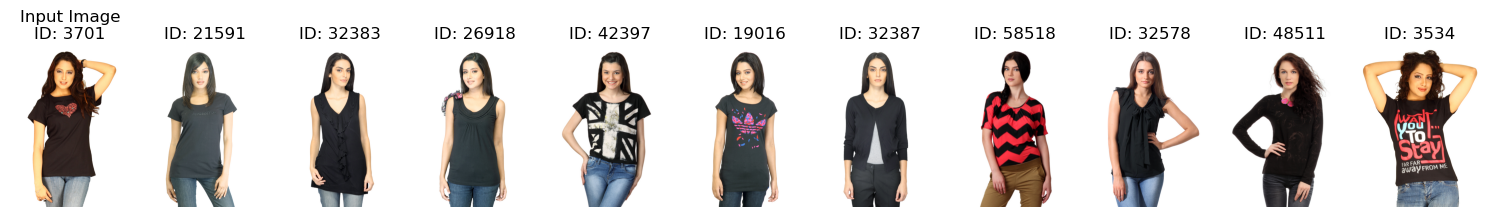

In [75]:
test_id = 3701  
test_similarity_for_sample_id(test_id, sampled_df, img_emb, encoded_metadata, model, encoder, categorical_columns, k=10)

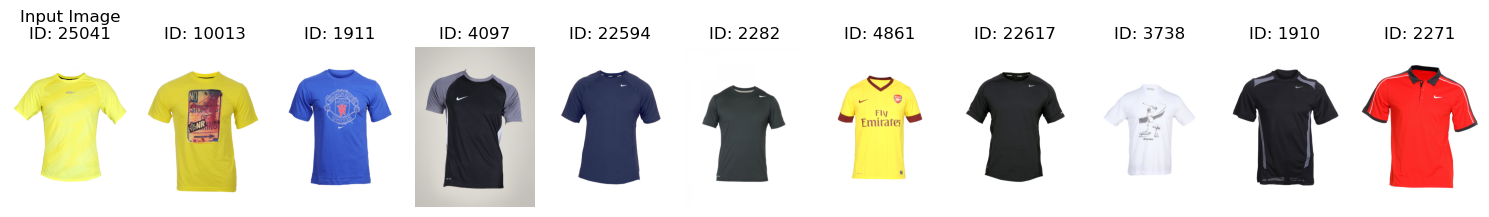

In [76]:
test_id = 25041  
test_similarity_for_sample_id(test_id, sampled_df, img_emb, encoded_metadata, model, encoder, categorical_columns, k=10)